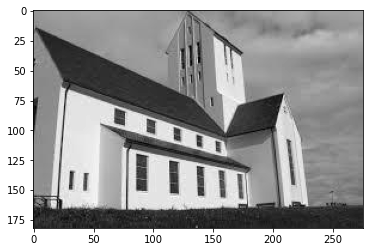

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
import cv2
import math

#Reading the image as grayscale image
image = cv2.imread('image1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

In [2]:
#To create the filter 
#Providing the value for sigma and T 
sigma = 0.5
T = 0.3
t = -np.log(T) * 2 * (sigma ** 2)
a=np.round(np.sqrt(t))
b=2*a + 1

In [3]:
#Generating gradient masks
#In Directions x and y
N = b
c = a
y, x = np.meshgrid(range(-int(c), int(c) + 1), range(-int(c), int(c) + 1))

#Gaussian
tmp = ((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))
gauss= (np.exp(-tmp))


In [4]:
#Calculating gradient_X
temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
gx= -((x * np.exp(-temp)) / sigma ** 2)
gx = (gx * 255)
gx= np.around(gx)

#Calculating gradient_Y 
temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
gy= -((y * np.exp(-temp)) / sigma ** 2)
gy = (gy * 255)
gy= np.around(gy)

In [5]:
#Padding and smoothing of image
i, j = gauss.shape
output = np.zeros((gray.shape[0], gray.shape[1])) 
img_row, img_col = gray.shape
k_row, k_col = gauss.shape
padded = np.zeros((img_row + k_row,img_col + k_col), dtype=gray.dtype)
insert = np.uint((k_row)/2)
padded[insert: insert + img_row, insert: insert + img_col] = gray
image_padded=padded
for x in range(gray.shape[0]):    
    for y in range(gray.shape[1]):
        output[x, y] = (gauss * image_padded[x:x+i, y:y+j]).sum() / gauss.sum() 
smooth_img= output


In [6]:
#Finding the Derivative along x direction
#Performing convolution between image and kernel Horizontally
i, j = gx.shape
gx = np.flipud(np.fliplr(gx))    
output = np.zeros_like(smooth_img)
img_row, img_col = smooth_img.shape
k_row, k_col = gx.shape
padded = np.zeros((img_row + k_row,img_col + k_col), dtype=smooth_img.dtype)
insert = np.uint((k_row)/2)
padded[insert: insert + img_row, insert: insert + img_col] = smooth_img
image_padded=padded
for x in range(smooth_img.shape[0]):    
    for y in range(smooth_img.shape[1]):
        output[x, y] = (gx * image_padded[x:x+i, y:y+j]).sum()        
Ix= output

In [7]:
#Finding the Derivative along x direction
#Performing convolution between image and kernel vertically  
i, j = gy.shape
gy = np.flipud(np.fliplr(gy))    
output = np.zeros_like(smooth_img)
img_row, img_col = smooth_img.shape
k_row, k_col = gy.shape
padded = np.zeros((img_row + k_row,img_col + k_col), dtype=smooth_img.dtype)
insert = np.uint((k_row)/2)
padded[insert: insert + img_row, insert: insert + img_col] = smooth_img
image_padded=padded
for x in range(smooth_img.shape[0]):    
    for y in range(smooth_img.shape[1]):
        output[x, y] = (gy * image_padded[x:x+i, y:y+j]).sum()        
Iy= output


In [8]:
#Calculating the magnitude of gradient
G = np.hypot(Ix,Iy)
G = G / G.max() * 255
#calculating the angle for direction
theta = np.arctan2(Iy, Ix)
mag=G
ang=theta

In [9]:
#Setting up the threshold values
weak_threshold = None
strong_threshold = None
max_mag = np.max(mag) 
if not weak_threshold:weak_threshold = max_mag * 0.1
if not strong_threshold:strong_threshold = max_mag * 0.5

In [10]:
# Finding the dimension(height, width) of the Image   
img_height, img_width = smooth_img.shape 

In [11]:
    # Looping through every pixel of the grayscale  
    for x in range(img_width): 
        for y in range(img_height): 
               
            grad_angle = ang[y, x] 
            grad_angle = abs(grad_angle-180) if abs(grad_angle)>180 else abs(grad_angle) 
               
            # Selecting pixels 
            # x axis direction 
            if grad_angle<= 22.5: 
                neighb_1_x, neighb_1_y = x-1, y 
                neighb_2_x, neighb_2_y = x + 1, y 
              
            # Diagonal 
            elif grad_angle>22.5 and grad_angle<=(22.5 + 45): 
                neighb_1_x, neighb_1_y = x-1, y-1
                neighb_2_x, neighb_2_y = x + 1, y + 1
              
            #Y-Axis  
            elif grad_angle>(22.5 + 45) and grad_angle<=(22.5 + 90): 
                neighb_1_x, neighb_1_y = x, y-1
                neighb_2_x, neighb_2_y = x, y + 1
              
            # Another Diagonal
            elif grad_angle>(22.5 + 90) and grad_angle<=(22.5 + 135): 
                neighb_1_x, neighb_1_y = x-1, y + 1
                neighb_2_x, neighb_2_y = x + 1, y-1
              
            # Doing the cycle again 
            elif grad_angle>(22.5 + 135) and grad_angle<=(22.5 + 180): 
                neighb_1_x, neighb_1_y = x-1, y 
                neighb_2_x, neighb_2_y = x + 1, y 
               
            # Non-maximum suppression 
            #Making changes in the magnitude
            if img_width>neighb_1_x>= 0 and img_height>neighb_1_y>= 0: 
                if mag[y, x]<mag[neighb_1_y, neighb_1_x]: 
                    mag[y, x]= 0
                    continue
   
            if img_width>neighb_2_x>= 0 and img_height>neighb_2_y>= 0: 
                if mag[y, x]<mag[neighb_2_y, neighb_2_x]: 
                    mag[y, x]= 0
   

In [12]:
#Creation of weak_ids and strong_ids and ids from image'img'
ids = np.zeros_like(smooth_img)

# Performing double thresholding 
for x in range(img_width): 
    for y in range(img_height): 
        grad_mag = mag[y, x] 
        if grad_mag<weak_threshold: 
            mag[y, x]= 0
        elif strong_threshold>grad_mag>= weak_threshold: 
            ids[y, x]= 1
        else: 
            ids[y, x]= 2
       

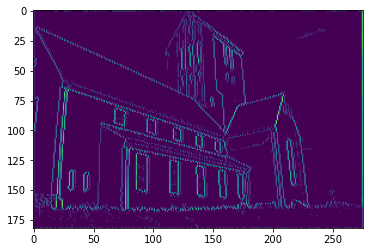

In [13]:
# The magnitude of the edges is the canny image 
canny_img=mag 
plt.imshow(canny_img)